In [1]:
import numpy as np
np.random.seed(1000)
import cv2
import os
from PIL import Image
import keras
os.environ["KERAS_BACKEND"]='tensorflow'

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2024-07-01 19:35:02.177263: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
image_directory = '/Users/pushkaraggarwal/Downloads/cell_images/'
SIZE = 64
dataset = []
label = []

parasitized_images = os.listdir(image_directory + 'Parasitized/')
for i,image_name in enumerate(parasitized_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'Parasitized/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE,SIZE))
        dataset.append(np.array(image))
        label.append(0)
uninfected_images = os.listdir(image_directory + 'Uninfected/')
for i,image_name in enumerate(uninfected_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'Uninfected/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE,SIZE))
        dataset.append(np.array(image))
        label.append(1)

In [5]:
INPUT_SHAPE = (SIZE, SIZE, 3)   #change to (SIZE, SIZE, 3)
inp = keras.layers.Input(shape=INPUT_SHAPE)

conv1 = keras.layers.Conv2D(32, kernel_size=(3, 3), 
                               activation='relu', padding='same')(inp)
pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
norm1 = keras.layers.BatchNormalization(axis = -1)(pool1)
drop1 = keras.layers.Dropout(rate=0.2)(norm1)
conv2 = keras.layers.Conv2D(32, kernel_size=(3, 3), 
                               activation='relu', padding='same')(drop1)
pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
norm2 = keras.layers.BatchNormalization(axis = -1)(pool2)
drop2 = keras.layers.Dropout(rate=0.2)(norm2)

flat = keras.layers.Flatten()(drop2)  #Flatten the matrix to get it ready for dense.

hidden1 = keras.layers.Dense(512, activation='relu')(flat)
norm3 = keras.layers.BatchNormalization(axis = -1)(hidden1)
drop3 = keras.layers.Dropout(rate=0.2)(norm3)
hidden2 = keras.layers.Dense(256, activation='relu')(drop3)
norm4 = keras.layers.BatchNormalization(axis = -1)(hidden2)
drop4 = keras.layers.Dropout(rate=0.2)(norm4)

out = keras.layers.Dense(2, activation='sigmoid')(drop4)   #units=1 gives error

model = keras.Model(inputs=inp, outputs=out)
model.compile(optimizer='adam',
                loss='categorical_crossentropy',   #Check between binary_crossentropy and categorical_crossentropy
                metrics=['accuracy'])
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        9248

Epoch 1/15
311/311 [==============================] - 116s 373ms/step - loss: 0.2177 - accuracy: 0.9187 - val_loss: 0.5297 - val_accuracy: 0.8313
Epoch 2/15
311/311 [==============================] - 105s 338ms/step - loss: 0.1837 - accuracy: 0.9341 - val_loss: 0.5362 - val_accuracy: 0.8463
Epoch 3/15
311/311 [==============================] - 101s 324ms/step - loss: 0.1659 - accuracy: 0.9382 - val_loss: 0.2679 - val_accuracy: 0.9197
Epoch 4/15
311/311 [==============================] - 86s 277ms/step - loss: 0.1417 - accuracy: 0.9492 - val_loss: 0.3165 - val_accuracy: 0.9179
Epoch 5/15
311/311 [==============================] - 87s 279ms/step - loss: 0.1235 - accuracy: 0.9544 - val_loss: 0.5958 - val_accuracy: 0.9156
Epoch 6/15
311/311 [==============================] - 87s 279ms/step - loss: 0.1059 - accuracy: 0.9617 - val_loss: 0.2154 - val_accuracy: 0.9420
Epoch 7/15
311/311 [==============================] - 83s 268ms/step - loss: 0.0880 - accuracy: 0.9678 - val_loss: 0.1846 - val

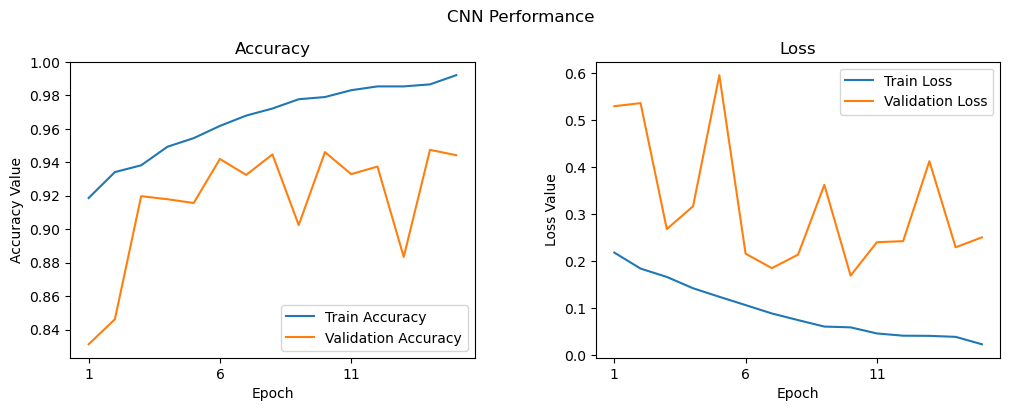

In [7]:
import sklearn
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(dataset, to_categorical(np.array(label)), test_size = 0.20, random_state = 0)

# When training with Keras's Model.fit(), adding the tf.keras.callback.TensorBoard callback 
# ensures that logs are created and stored. Additionally, enable histogram computation 
#every epoch with histogram_freq=1 (this is off by default)
#Place the logs in a timestamped subdirectory to allow easy selection of different training runs.

#import datetime

#log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + "/"
#tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


# ### Training the model
# As the training data is now ready, I will use it to train the model.   

#Fit the model
history = model.fit(np.array(X_train), 
                         y_train, 
                         batch_size = 64, 
                         verbose = 1, 
                         epochs = 15,      #Changed to 3 from 50 for testing purposes.
                         validation_split = 0.1,
                         shuffle = False
                      #   callbacks=callbacks
                     )

# ## Accuracy calculation
# 
# I'll now calculate the accuracy on the test data.

print("Test_Accuracy: {:.2f}%".format(model.evaluate(np.array(X_test), np.array(y_test))[1]*100))


import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")


#Save the model
model.save('malaria_cnn.h5')

